## Druga część projektu

In [1]:

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import shuffle

In [2]:
# pip install xgboost

In [3]:
# pip install catboost

### wczytanie wszystkich zbiorow danych i podział na zbiór testowy i treningowy

In [4]:
split_ratio = 0.8
train_datasets = {}
test_datasets = {}

for name in ["mean_min_max", "median_min_max", "knn_min_max", "mean_standard", "median_standard", "knn_standard"]:
    df = pd.read_csv(f"{name}.csv")

    df = shuffle(df, random_state=42).reset_index(drop=True)

    split_index = int(len(df) * split_ratio)

    train_datasets[name] = df[:split_index]
    test_datasets[name] = df[split_index:]

for name in train_datasets:
    print(f"{name} - Zbiór treningowy: {train_datasets[name].shape}, Zbiór testowy: {test_datasets[name].shape}")

mean_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_min_max - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
mean_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
median_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)
knn_standard - Zbiór treningowy: (409778, 21), Zbiór testowy: (102445, 21)


### dwa podstawowe modele regresji

In [5]:
# linear_regression_results = {}

# for name in train_datasets:
#     X_train = train_datasets[name].drop(columns=["sellingprice"])
#     y_train = train_datasets[name]["sellingprice"]
#     X_test = test_datasets[name].drop(columns=["sellingprice"])
#     y_test = test_datasets[name]["sellingprice"]

#     linear_model = LinearRegression()
#     linear_model.fit(X_train, y_train)

#     y_pred = linear_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     linear_regression_results[name] = {
#         "MSE": mse,
#         "R^2": r2
#     }

#     print(f"Regresja Liniowa - Zbiór: {name}")
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"R^2 Score: {r2:.2f}")
#     print("-" * 30)


In [6]:
# random_forest_results = {}

# for name in train_datasets:
#     X_train = train_datasets[name].drop(columns=["sellingprice"])
#     y_train = train_datasets[name]["sellingprice"]
#     X_test = test_datasets[name].drop(columns=["sellingprice"])
#     y_test = test_datasets[name]["sellingprice"]

#     rf_model = RandomForestRegressor(random_state=42)
#     rf_model.fit(X_train, y_train)

#     y_pred = rf_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     random_forest_results[name] = {
#         "MSE": mse,
#         "R^2": r2
#     }

#     print(f"Random Forest - Zbiór: {name}")
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"R^2 Score: {r2:.2f}")
#     print("-" * 30)

Regresja liniowa wykonuje się bardzo szybko, las losowy bardzo długo - dla każdego zbioru kilkanaście/kilkadziesiąt minut.

### wizualizacja wynikow

In [7]:
# sns.set(style="whitegrid")

# def plot_comparison_metrics(linear_regression_results, random_forest_results):
#     datasets = list(linear_regression_results.keys())

#     mse_lr = [linear_regression_results[dataset]['MSE'] for dataset in datasets]
#     r2_lr = [linear_regression_results[dataset]['R^2'] for dataset in datasets]

#     mse_rf = [random_forest_results[dataset]['MSE'] for dataset in datasets]
#     r2_rf = [random_forest_results[dataset]['R^2'] for dataset in datasets]

#     plt.figure(figsize=(10, 6))
#     bar_width = 0.4
#     plt.bar(datasets, mse_lr, width=bar_width, label="Linear Regression MSE", color="skyblue", align='center')
#     plt.bar(datasets, mse_rf, width=bar_width, label="Random Forest MSE", color="lightcoral", align='edge')

#     plt.xlabel('Zbiór danych')
#     plt.ylabel('MSE')
#     plt.title('Porównanie MSE dla Regresji Liniowej i Random Forest')
#     plt.legend(loc='upper left')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 6))
#     plt.scatter(datasets, r2_lr, label="Linear Regression R^2", color="salmon", s=100, zorder=5)
#     plt.scatter(datasets, r2_rf, label="Random Forest R^2", color="lightgreen", s=100, zorder=5)

#     plt.xlabel('Zbiór danych')
#     plt.ylabel('R²')
#     plt.title('Porównanie R² dla Regresji Liniowej i Random Forest')
#     plt.legend(loc='upper left')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# plot_comparison_metrics(linear_regression_results, random_forest_results)

## dobór metryk

In [8]:
def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## 3 modele z scikit-learn oraz 2 modele z innych bibliotek oraz modele zespołowe

Model SVR (Support Vector Regression) okazał się nieodpowiedni do naszych danych, najprawdopodobniej z uwagi na sposób kodowania zmiennych kategorycznych. Zastosowanie label encodingu (przekształcenie kategorii na wartości liczbowe) mogło prowadzić do nadmiernego wzrostu złożoności obliczeniowej. SVR jest wrażliwy na duże rozmiary danych oraz skalowanie cech, a w tym przypadku przetwarzanie danych przekraczało dostępne zasoby pamięci zarówno w środowisku lokalnym, jak i w Google Colab. Proces trenowania modelu trwał bardzo długo i kończył się zawieszeniem programu.

Modele Random Forest oraz CatBoost i XGBoost nie zostały uwzględnione w modelach zespołowych ze względu na bardzo długi czas wykonywania.

In [9]:
results = []

for name in train_datasets:
    print(f"Praca na zbiorze: {name}")

    train_df = train_datasets[name]
    test_df = test_datasets[name]

    X_train = train_df.drop(columns=["sellingprice"])
    y_train = train_df["sellingprice"]
    X_test = test_df.drop(columns=["sellingprice"])
    y_test = test_df["sellingprice"]

    models = {
        "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
        "LinearRegression": LinearRegression(),
        #"SVR": SVR(),
        "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(random_state=42, silent=True),
        "Voting Regressor": VotingRegressor(estimators=[
            ('lr', LinearRegression()),
            ('hgb', HistGradientBoostingRegressor(random_state=42)),
            ('en', ElasticNet())
        ]),
        "Stacking Regressor": StackingRegressor(
            estimators=[
                ('lr', LinearRegression()),
                ('hgb', HistGradientBoostingRegressor(random_state=42)),
                ('en', ElasticNet())
            ],
            final_estimator=LinearRegression()
        )
    }

    for model_name, model in models.items():
        print(f"Trening modelu: {model_name}")

        start_time = time.time()

        model.fit(X_train, y_train)

        end_time = time.time()

        y_pred = model.predict(X_test)

        mae = custom_mae(y_test, y_pred)
        rmse = custom_rmse(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        training_time = end_time - start_time

        results.append({
            "Dataset": name,
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2,
            "MAPE": mape,
            "Training Time (seconds)": training_time
        })

Praca na zbiorze: mean_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Trening modelu: Voting Regressor
Trening modelu: Stacking Regressor
Praca na zbiorze: median_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Trening modelu: Voting Regressor
Trening modelu: Stacking Regressor
Praca na zbiorze: knn_min_max
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Trening modelu: Voting Regressor
Trening modelu: Stacking Regressor
Praca na zbiorze: mean_standard
Trening modelu: RandomForest
Trening modelu: LinearRegression
Trening modelu: HistGradientBoostingRegressor
Trening modelu: XGBoost
Trening modelu: CatBoost
Trening modelu: Voting Regressor
Trening m

In [10]:
results_df = pd.DataFrame(results)

## podsumowanie

In [11]:
print("\nWyniki dla każdego modelu i zbioru danych:")
results_df


Wyniki dla każdego modelu i zbioru danych:


,Dataset,Model,MAE,RMSE,R²,MAPE,Training Time (seconds)
0,mean_min_max,RandomForest,0.026048,0.039195,0.968885,12.421516,187.898131
1,mean_min_max,LinearRegression,0.028074,0.042012,0.964252,14.008762,2.726032
2,mean_min_max,HistGradientBoostingRegressor,0.025588,0.038294,0.970300,12.207046,5.682998
3,mean_min_max,XGBoost,0.024886,0.037412,0.971652,11.689896,5.171998
4,mean_min_max,CatBoost,0.024627,0.036911,0.972407,11.564949,47.860001
5,mean_min_max,Voting Regressor,0.065400,0.082988,0.860514,49.292124,6.383029
6,mean_min_max,Stacking Regressor,0.025575,0.038244,0.970378,12.154732,32.803243
7,median_min_max,RandomForest,0.026044,0.039189,0.968895,12.417655,156.710108
8,median_min_max,LinearRegression,0.028074,0.042012,0.964252,14.008762,2.223999
9,median_min_max,HistGradientBoostingRegressor,0.025555,0.038270,0.970337,12.196443,5.800003


In [12]:
best_model = results_df.loc[results_df['MAE'].idxmin()]
print("\nNajlepszy model:")
best_model


Najlepszy model:


Dataset                    median_min_max
Model                            CatBoost
MAE                              0.024592
RMSE                             0.036882
R²                                0.97245
MAPE                            11.548103
Training Time (seconds)         56.238907
Name: 11, dtype: object

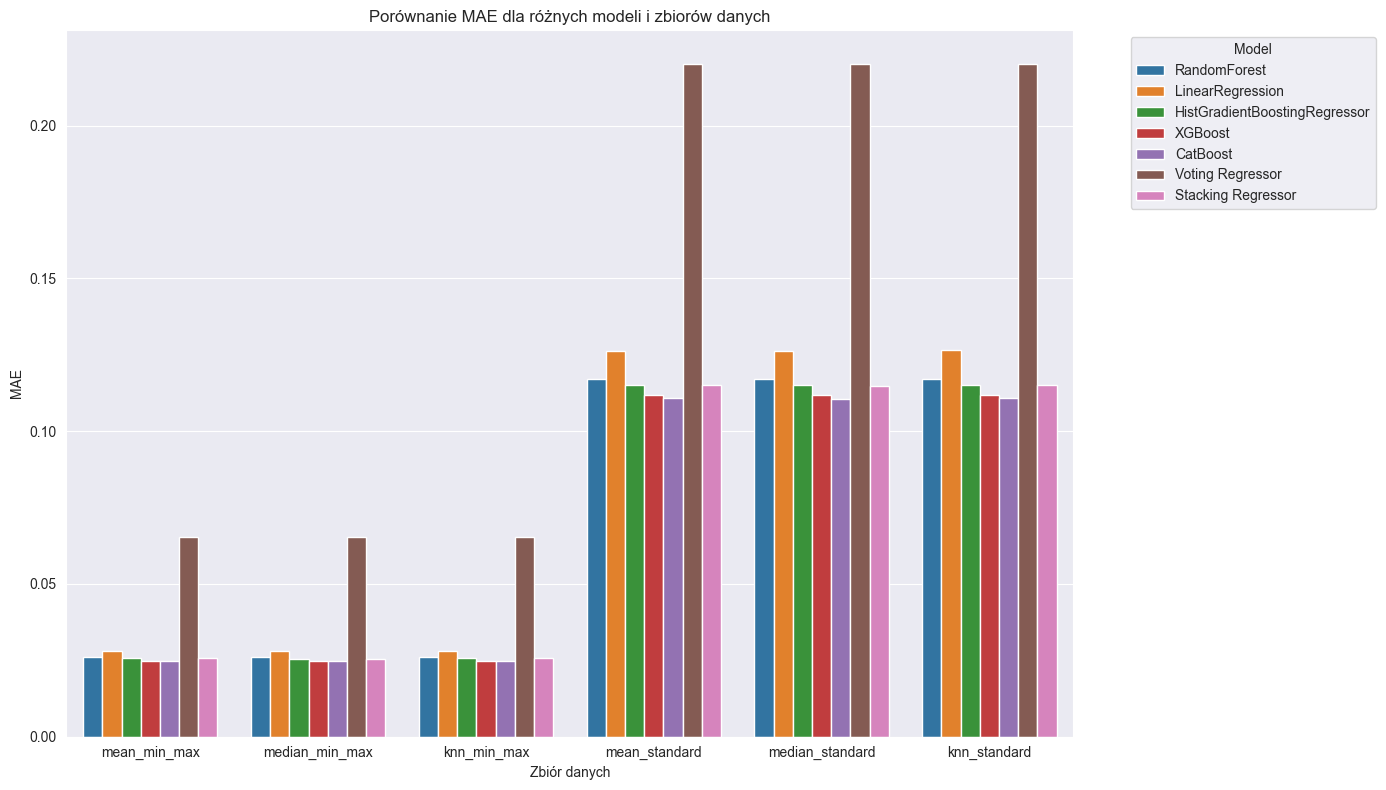

In [13]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Dataset', y='MAE', hue='Model')
plt.title('Porównanie MAE dla różnych modeli i zbiorów danych')
plt.ylabel('MAE')
plt.xlabel('Zbiór danych')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('mea.png', dpi=300, facecolor='white')
plt.show()

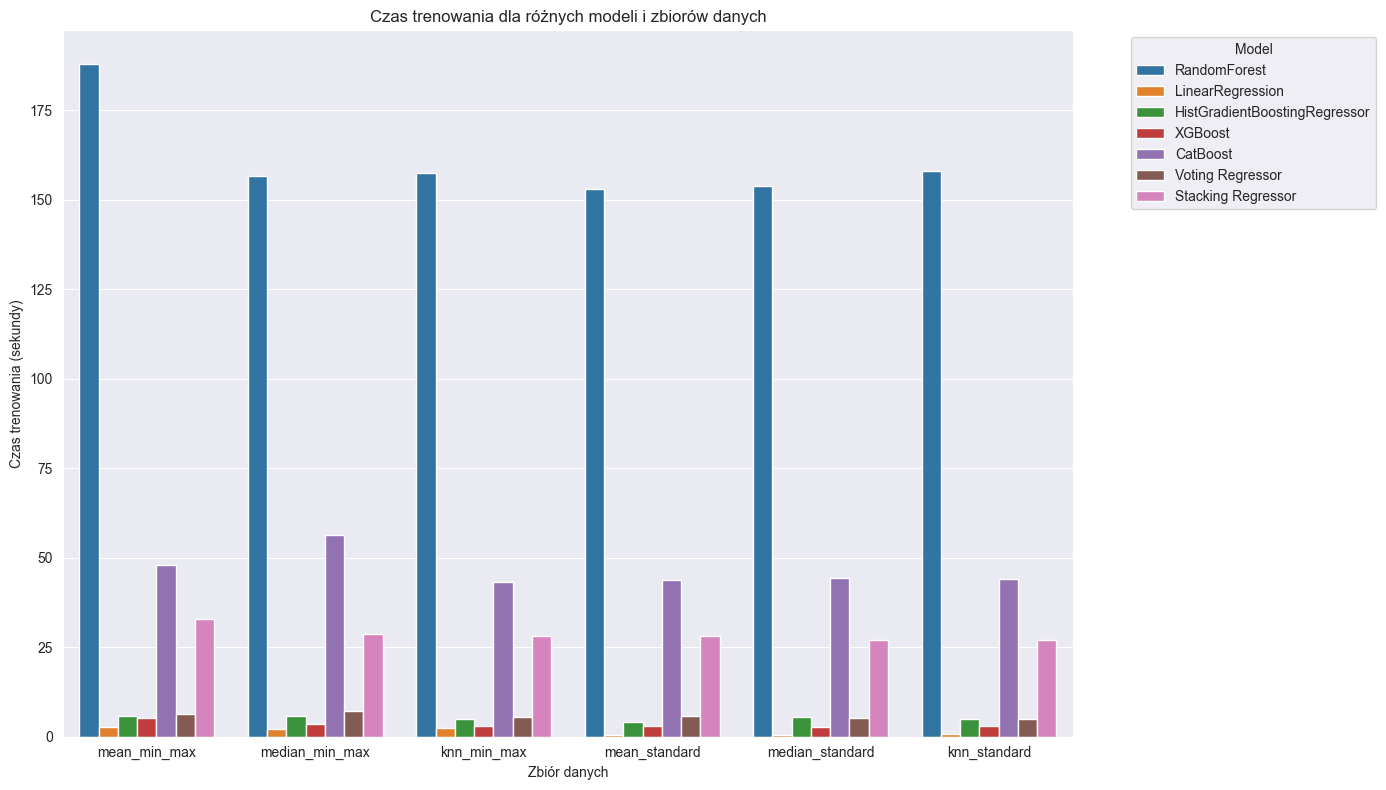

In [14]:
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Dataset', y='Training Time (seconds)', hue='Model')
plt.title('Czas trenowania dla różnych modeli i zbiorów danych')
plt.ylabel('Czas trenowania (sekundy)')
plt.xlabel('Zbiór danych')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('czasy_rozne_modele.png', dpi=300, facecolor='white')
plt.show()

* Wskaźniki MAE, RMSE oraz R² wskazują, że CatBoost i XGBoost osiągają najlepsze wyniki na większości zbiorów danych.
* CatBoost uzyskał minimalne wartości MAE i RMSE oraz najwyższy R², co sugeruje jego przewagę w dokładności predykcji.
* Modele Linear Regression i XGBoost charakteryzują się bardzo krótkim czasem trenowania, zaledwie kilka sekund na każdym zbiorze danych.
* RandomForest wymaga znacznie więcej czasu obliczeniowego, co czyni go najmniej wydajnym w kontekście tych danych.
* Wszystkie modele uzyskały lepsze wyniki (niższe MAE i RMSE) na danych przetworzonych za pomocą metod min-max scaling niż na danych standaryzowanych.

## Walidacja krzyżowa

In [15]:
def manual_cross_validation(model, X, y, n_splits=5):
    indices = np.arange(len(X))
    np.random.seed(42)
    np.random.shuffle(indices)

    folds = np.array_split(indices, n_splits)

    mae_scores, rmse_scores, r2_scores = [], [], []

    for i in range(n_splits):
        val_indices = folds[i]
        train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != i])

        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        mae_scores.append(custom_mae(y_val, y_pred))
        rmse_scores.append(custom_rmse(y_val, y_pred))
        r2_scores.append(r2_score(y_val, y_pred))

    return {
        "MAE": np.mean(mae_scores),
        "RMSE": np.mean(rmse_scores),
        "R2": np.mean(r2_scores),
    }


datasets = ["mean_min_max", "median_min_max", "knn_min_max", "mean_standard", "median_standard", "knn_standard"]
final_results = []

for name in datasets:
    df = pd.read_csv(f"{name}.csv")
    print(f"Wczytano zbiór: {name} - Rozmiar: {df.shape}")

    X = df.drop(columns=["sellingprice"]).values
    y = df["sellingprice"].values

    models = {
        "LinearRegression": LinearRegression(),
        "XGBoost": xgb.XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(random_state=42, silent=True),
        "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
        "Voting Regressor": VotingRegressor(estimators=[
            ('lr', LinearRegression()),
            ('hgb', HistGradientBoostingRegressor(random_state=42)),
            ('en', ElasticNet())
        ]),
        "Stacking Regressor": StackingRegressor(
            estimators=[
                ('lr', LinearRegression()),
                ('hgb', HistGradientBoostingRegressor(random_state=42)),
                ('en', ElasticNet())
            ],
            final_estimator=LinearRegression()
        )
    }

    results = []
    for model_name, model in models.items():
        manual_results = manual_cross_validation(model, X, y, n_splits=5)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        sklearn_mae = -np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error'))
        sklearn_rmse = np.mean(np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')))
        sklearn_r2 = np.mean(cross_val_score(model, X, y, cv=kf, scoring='r2'))

        results.append({
            "Dataset": name,
            "Model": model_name,
            "Manual MAE": manual_results["MAE"],
            "Sklearn MAE": sklearn_mae,
            "Manual RMSE": manual_results["RMSE"],
            "Sklearn RMSE": sklearn_rmse,
            "Manual R2": manual_results["R2"],
            "Sklearn R2": sklearn_r2,
        })

    final_results.extend(results)

Wczytano zbiór: mean_min_max - Rozmiar: (512223, 21)
Wczytano zbiór: median_min_max - Rozmiar: (512223, 21)
Wczytano zbiór: knn_min_max - Rozmiar: (512223, 21)
Wczytano zbiór: mean_standard - Rozmiar: (512223, 21)
Wczytano zbiór: median_standard - Rozmiar: (512223, 21)
Wczytano zbiór: knn_standard - Rozmiar: (512223, 21)


In [16]:
final_results_df = pd.DataFrame(final_results)

print("Wyniki cross-walidacji:")
final_results_df

Wyniki cross-walidacji:


,Dataset,Model,Manual MAE,Sklearn MAE,Manual RMSE,Sklearn RMSE,Manual R2,Sklearn R2
0,mean_min_max,LinearRegression,0.028125,0.028125,0.042104,0.042104,0.964139,0.964139
1,mean_min_max,XGBoost,0.024906,0.024907,0.037639,0.037616,0.971340,0.971375
2,mean_min_max,CatBoost,0.024669,0.024676,0.037222,0.037232,0.971972,0.971957
3,mean_min_max,HistGradientBoosting,0.025667,0.025650,0.038547,0.038553,0.969942,0.969933
4,mean_min_max,Voting Regressor,0.065545,0.065536,0.083119,0.083114,0.860243,0.860257
5,mean_min_max,Stacking Regressor,0.025653,0.025713,0.038502,0.038597,0.970012,0.969864
6,median_min_max,LinearRegression,0.028125,0.028125,0.042104,0.042104,0.964139,0.964139
7,median_min_max,XGBoost,0.024905,0.024896,0.037649,0.037621,0.971326,0.971368
8,median_min_max,CatBoost,0.024665,0.024675,0.037220,0.037219,0.971975,0.971976
9,median_min_max,HistGradientBoosting,0.025663,0.025659,0.038550,0.038560,0.969937,0.969922


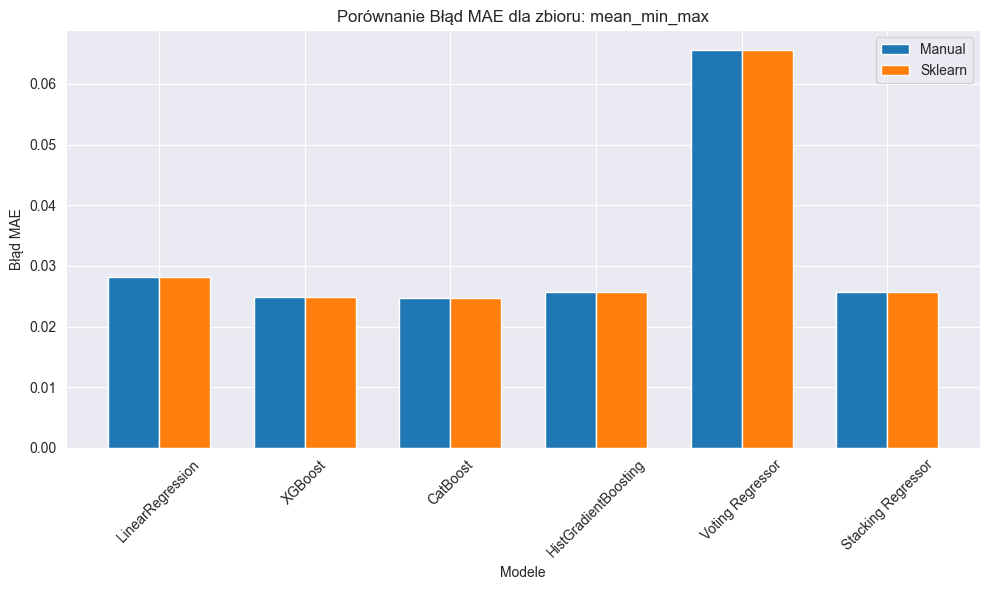

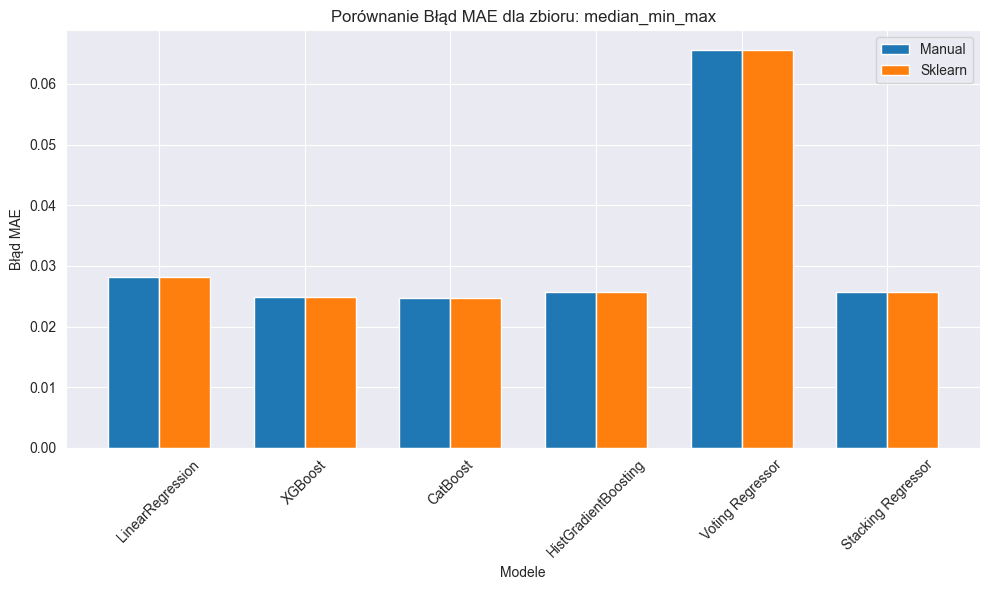

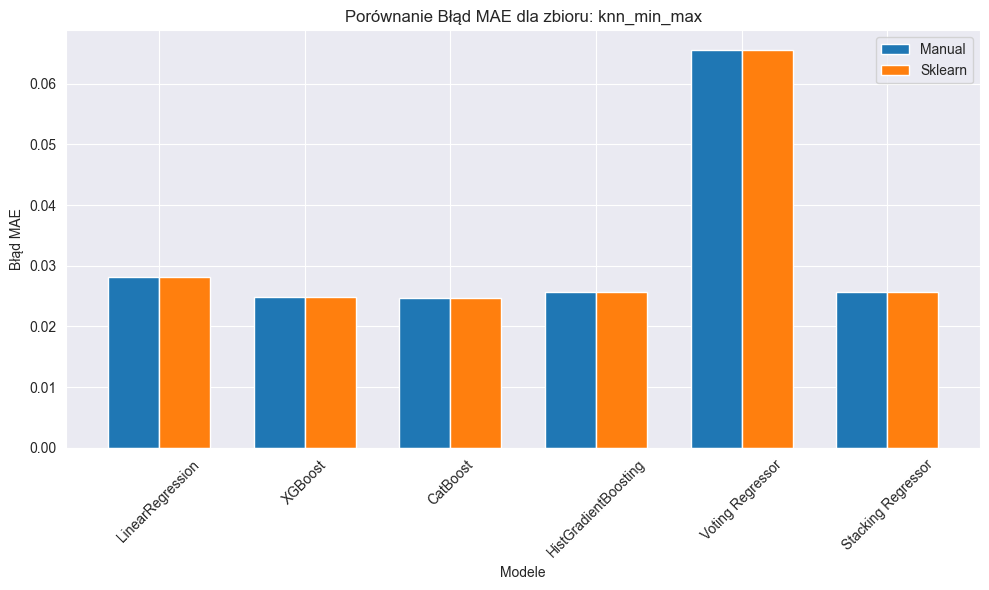

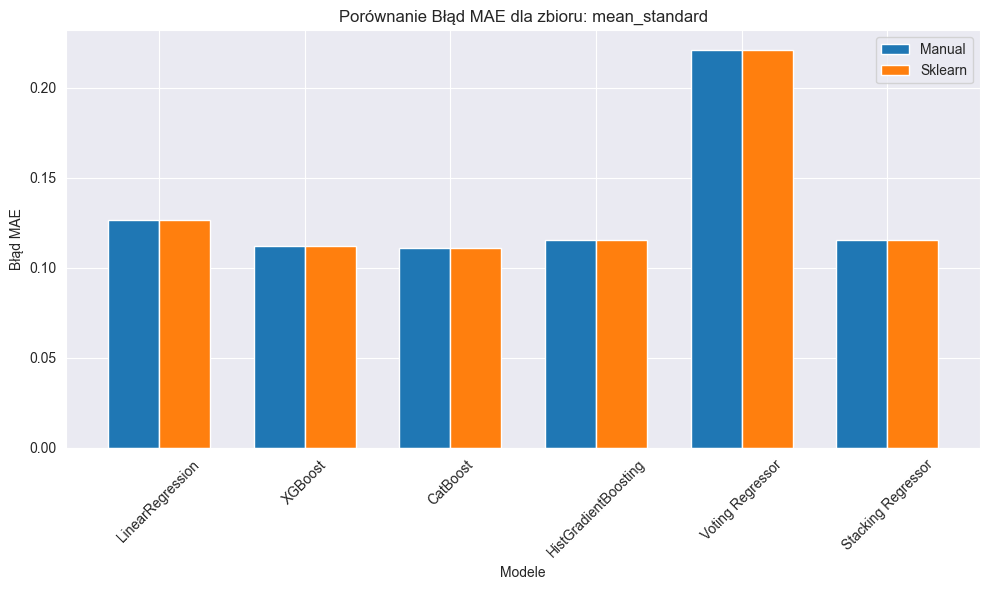

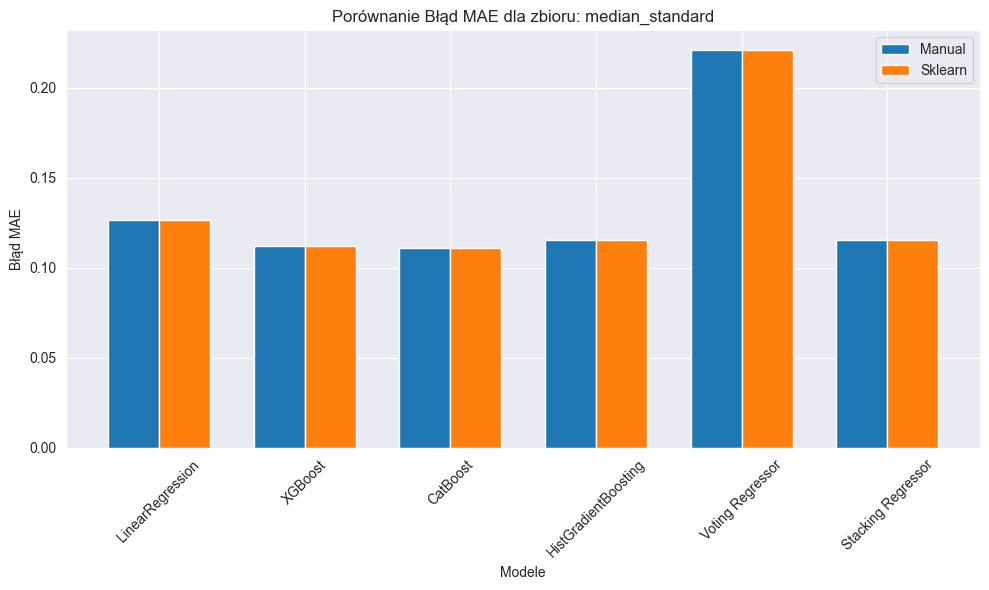

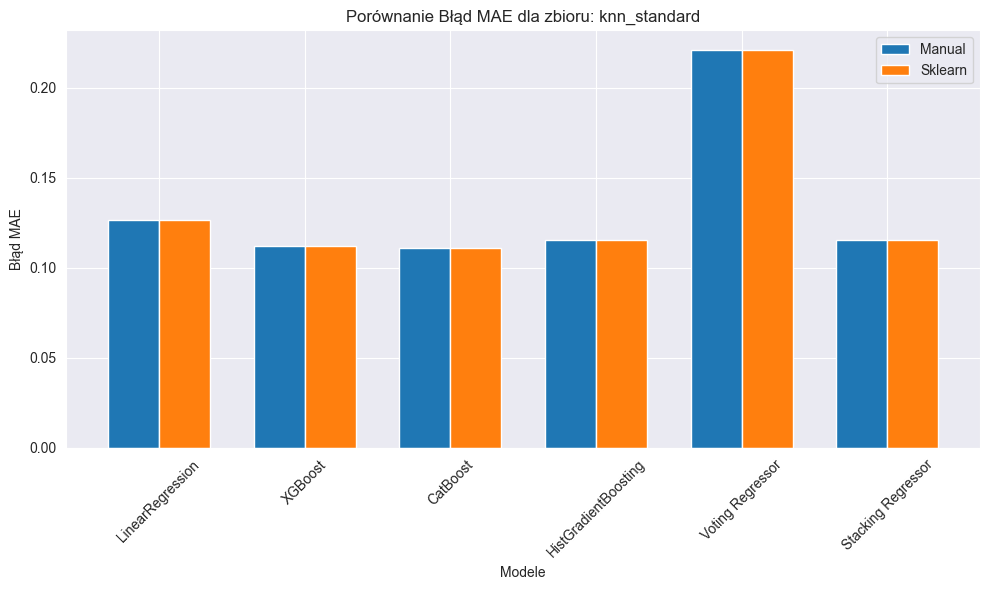

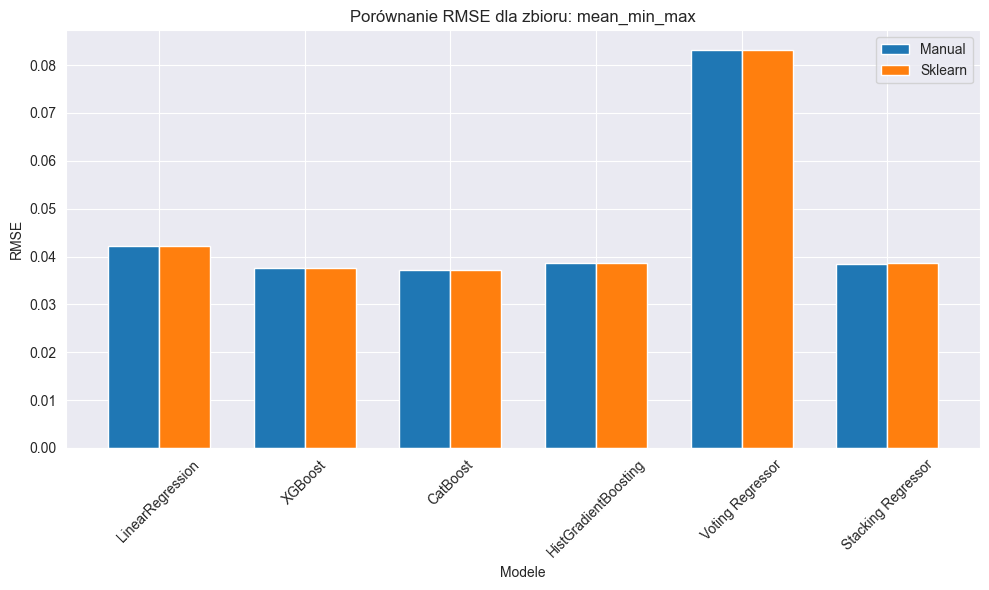

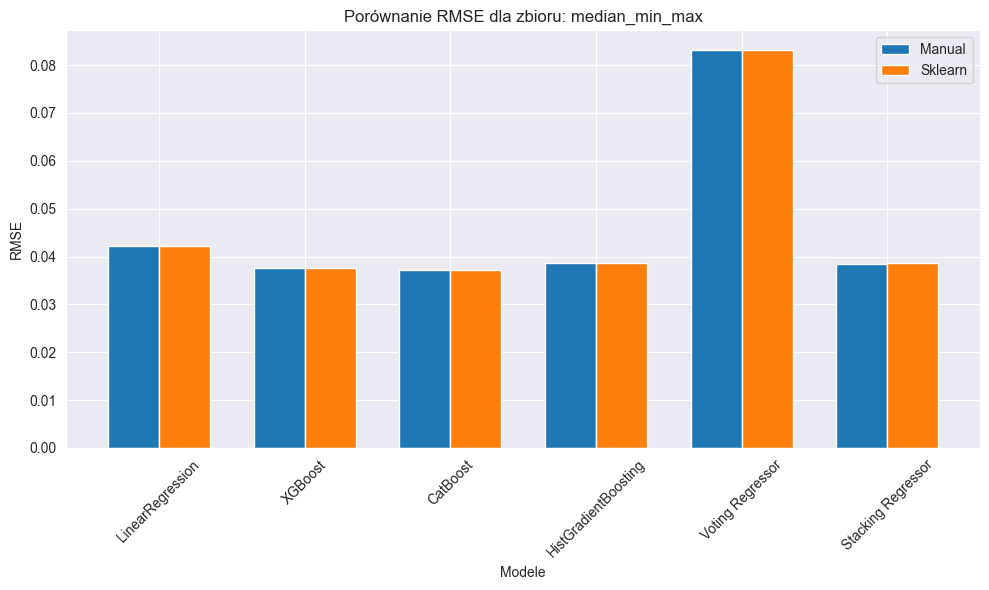

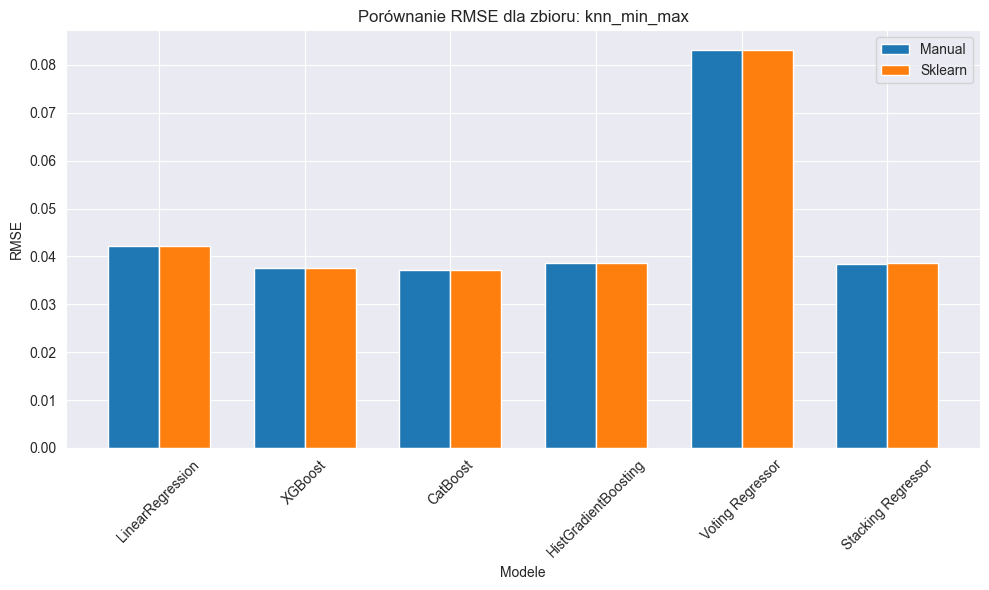

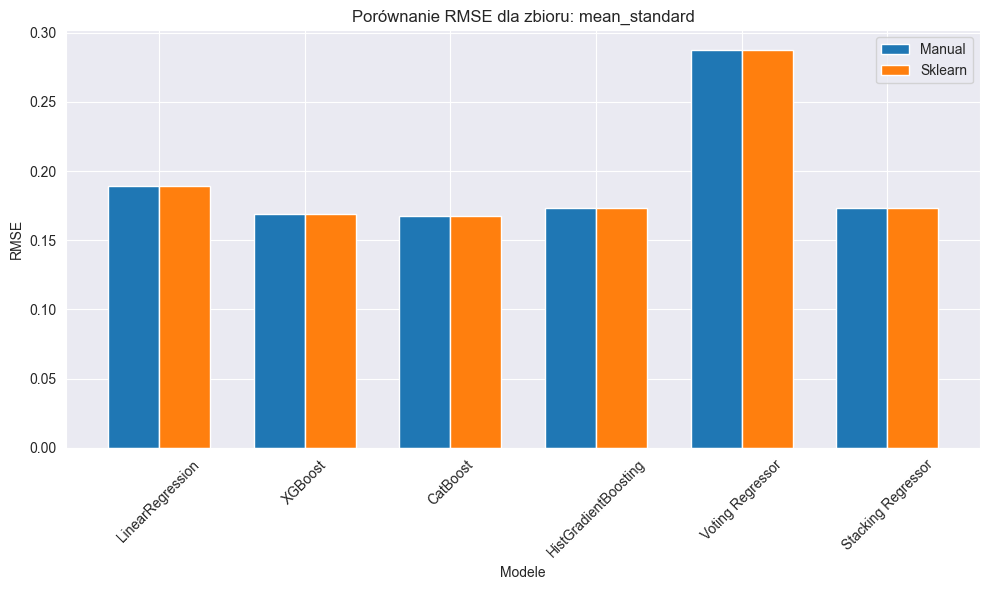

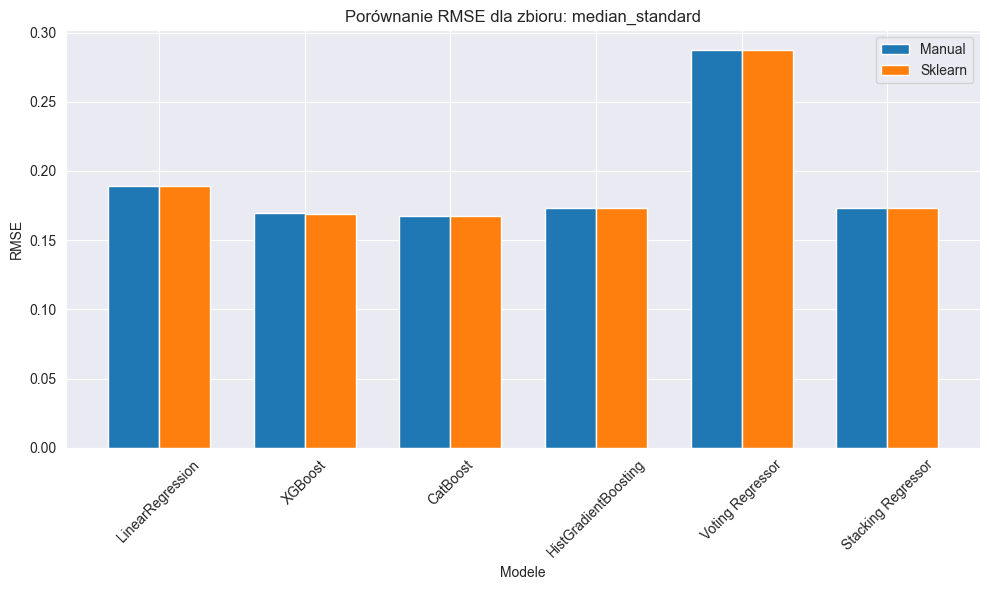

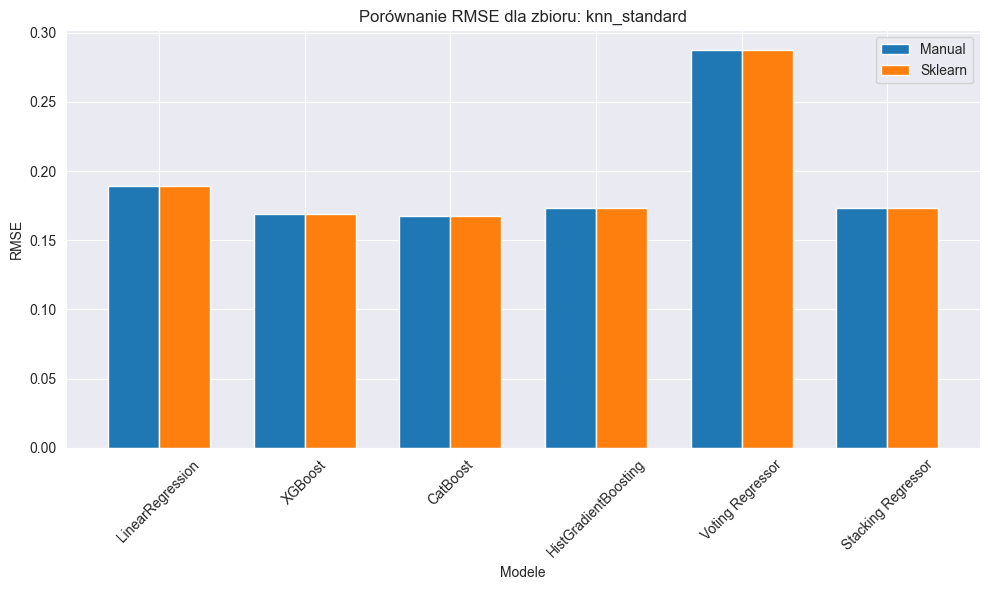

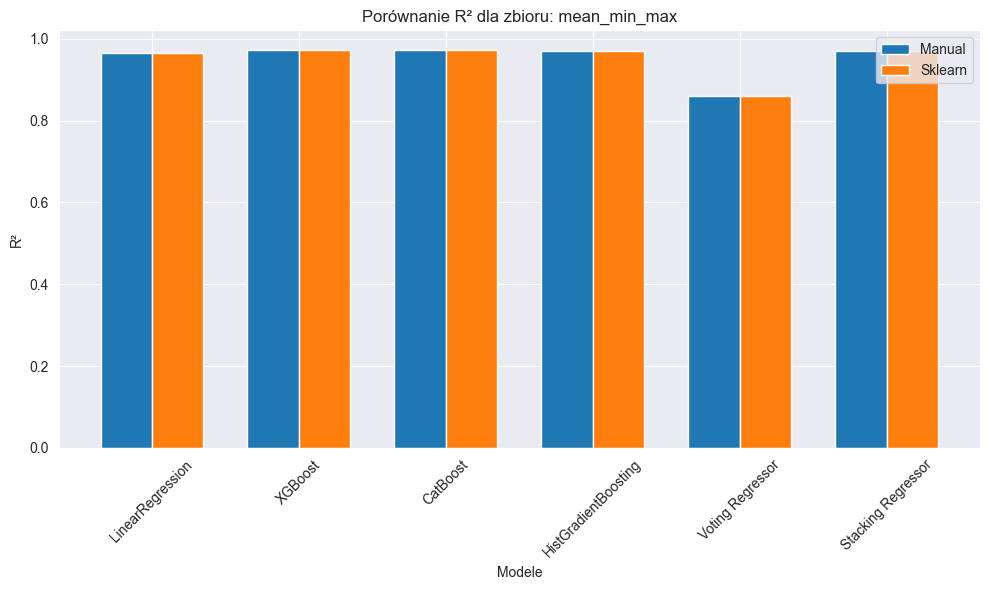

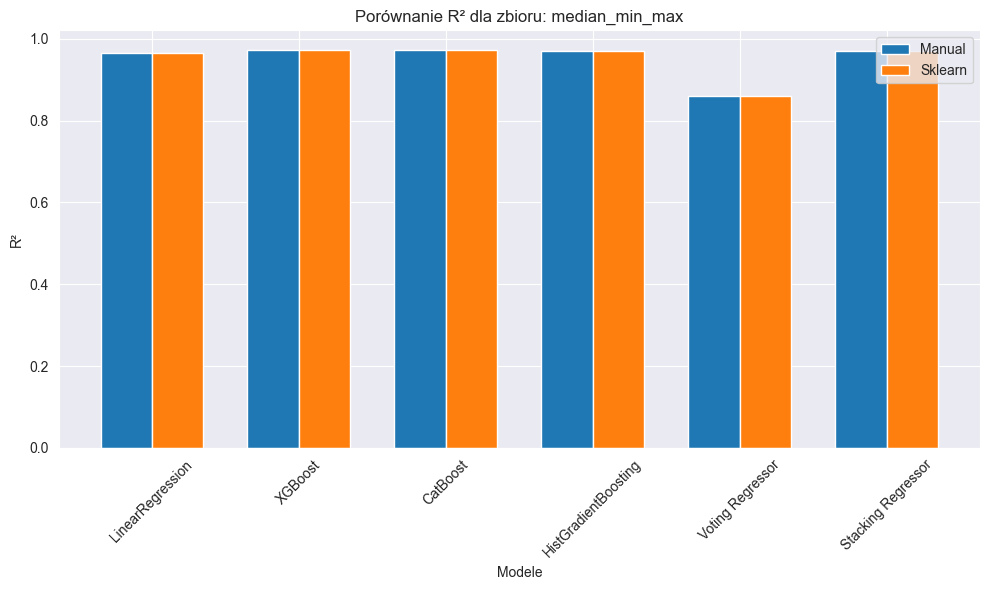

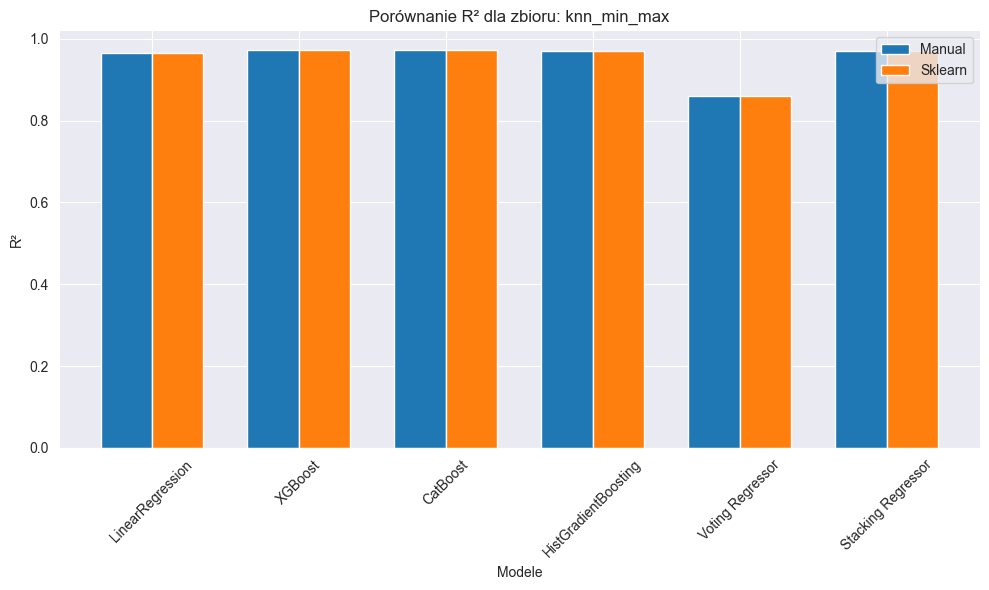

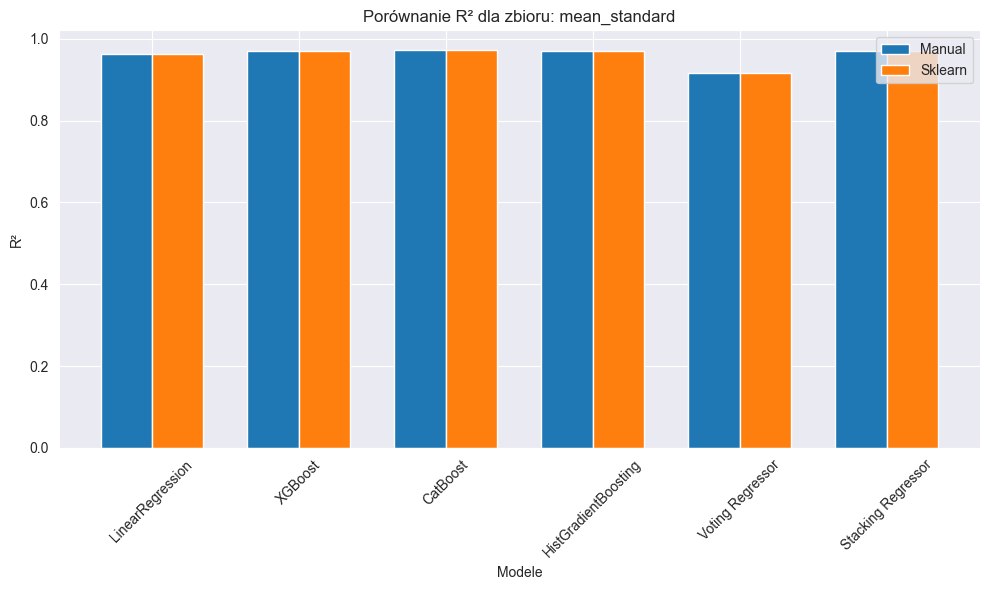

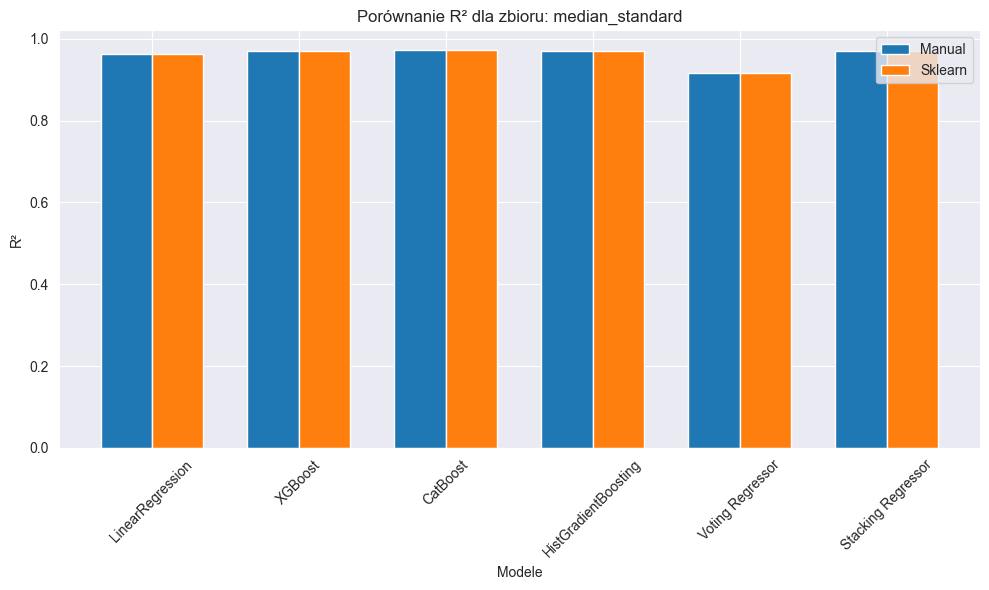

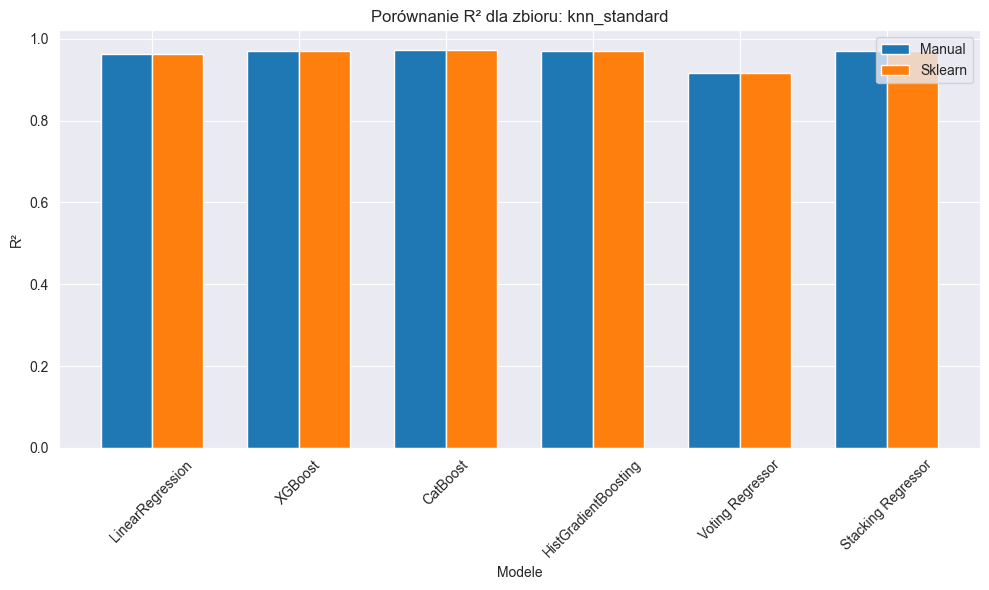

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def plot_separate_datasets(results_df, metric, metric_label):
    datasets = results_df["Dataset"].unique()

    for dataset in datasets:
        dataset_results = results_df[results_df["Dataset"] == dataset]

        models = dataset_results["Model"].values
        manual_values = dataset_results[f"Manual {metric}"].values
        sklearn_values = dataset_results[f"Sklearn {metric}"].values

        x = np.arange(len(models))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width / 2, manual_values, width=width, label="Manual")
        plt.bar(x + width / 2, sklearn_values, width=width, label="Sklearn")

        plt.xticks(x, models, rotation=45)
        plt.xlabel("Modele")
        plt.ylabel(metric_label)
        plt.title(f"Porównanie {metric_label} dla zbioru: {dataset}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"porownanie_{metric_label}_dla_zbioru_{dataset}.png", dpi=300, facecolor='white')
        plt.show()


plot_separate_datasets(final_results_df, "MAE", "Błąd MAE")
plot_separate_datasets(final_results_df, "RMSE", "RMSE")
plot_separate_datasets(final_results_df, "R2", "R²")


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyswarm import pso
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('mean_min_max.csv')

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numeric_columns].drop(columns=['sellingprice'])
y = data['sellingprice']

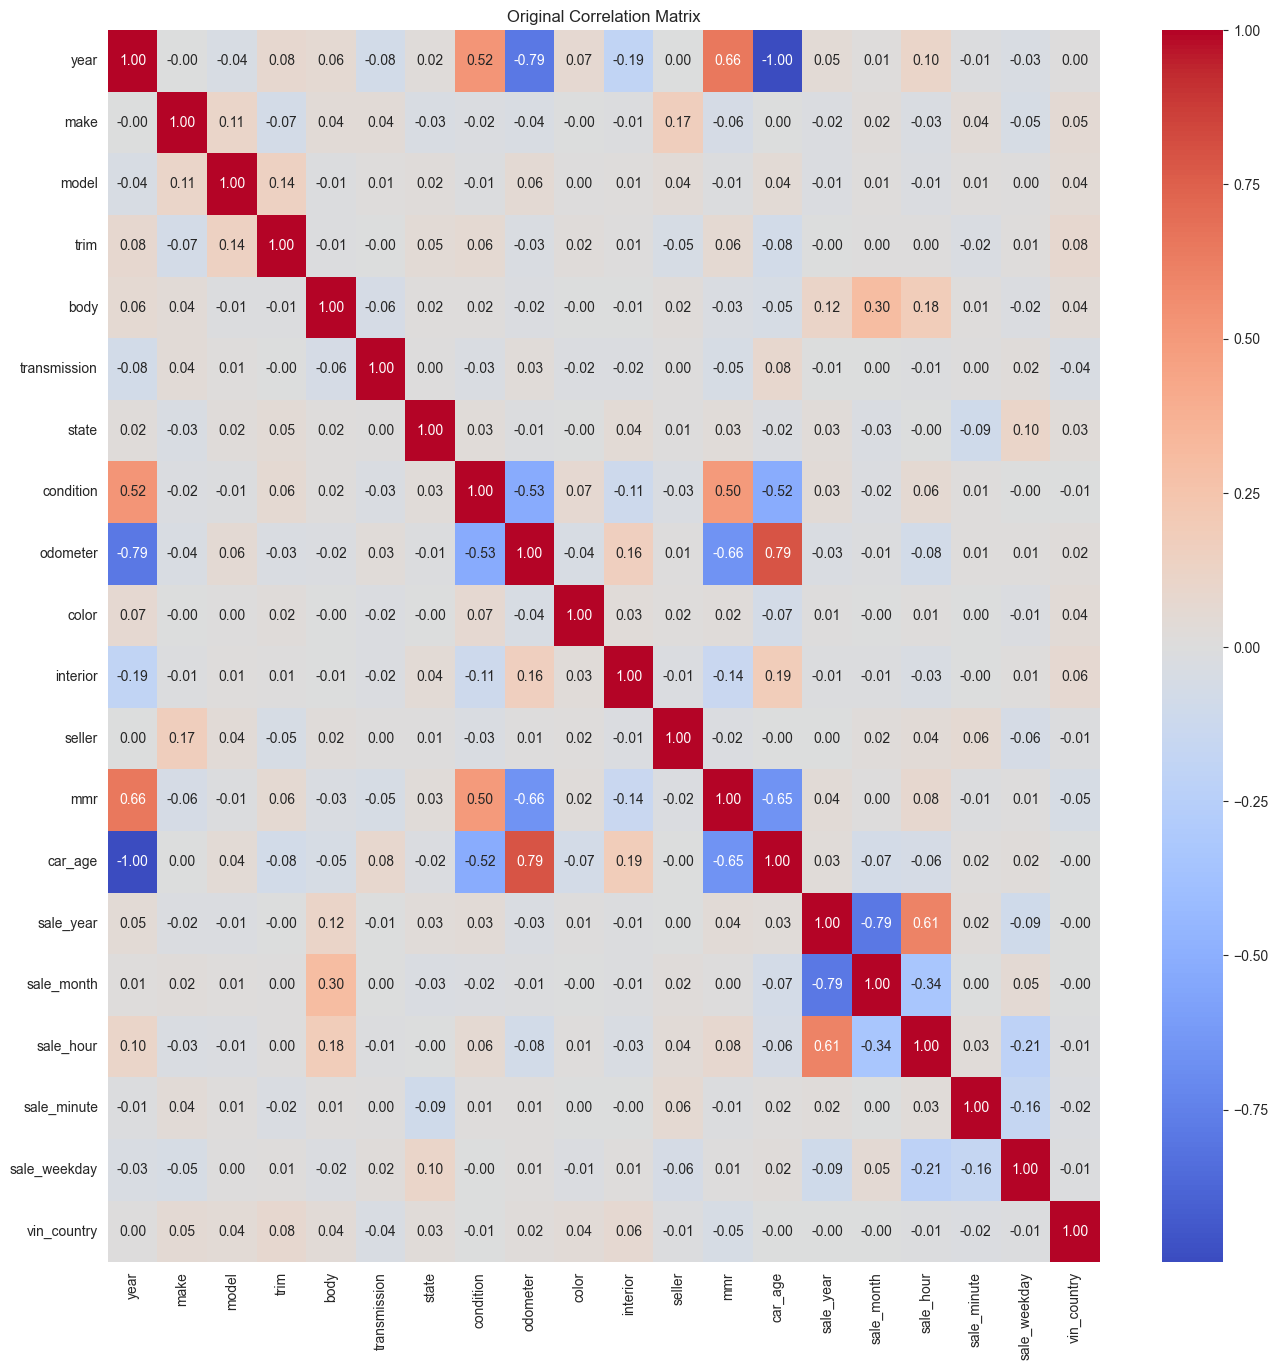

In [19]:
corr_matrix = X.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Original Correlation Matrix")
plt.savefig('original_correlation_matrix.png', dpi=300, facecolor='white')
plt.show()

Features removed based on correlation thresholds: ['mmr', 'condition', 'vin_country', 'car_age', 'sale_month', 'odometer', 'color', 'sale_year', 'transmission']


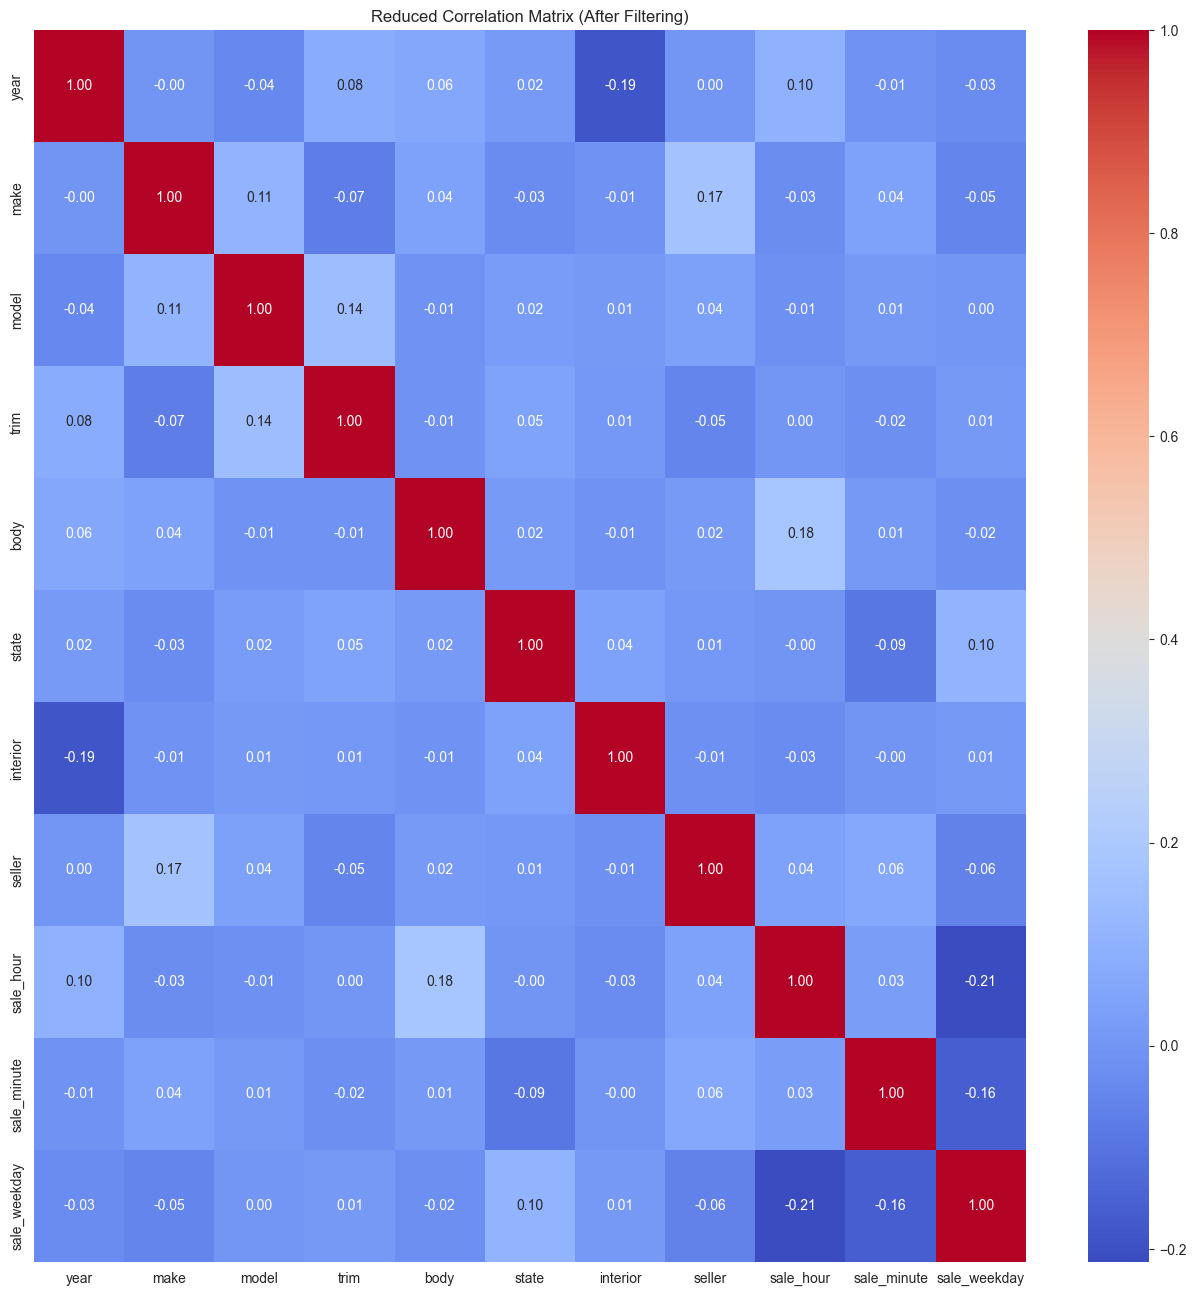

In [21]:
low_threshold = 0.1

features_to_drop_low = [col for col in corr_matrix if corr_matrix[col].drop(col).abs().max() < low_threshold]
features_to_drop_high = ['car_age', 'odometer', 'sale_year', 'condition', 'mmr', 'sale_month']

features_to_drop = list(set(features_to_drop_low + features_to_drop_high))
X_reduced = X.drop(columns=features_to_drop)

print(f"Features removed based on correlation thresholds: {features_to_drop}")

reduced_corr_matrix = X_reduced.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(reduced_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Reduced Correlation Matrix (After Filtering)")
plt.savefig('reduced_correlation_matrix.png', dpi=300, facecolor='white')
plt.show()

In [22]:
# Podział na zbiory: treningowy, walidacyjny i testowy (po redukcji cech)
# 1. Podział na zbiór testowy oraz zbiór treningowo-walidacyjny
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# 2. Podział zbioru treningowo-walidacyjnego na zbiór treningowy i walidacyjny
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)

print(f"Rozmiary zbiorów: \nTrain: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

Rozmiary zbiorów: 
Train: (307333, 11), Valid: (102445, 11), Test: (102445, 11)


    Features       MSE
0          1  0.029115
1          2  0.029076
2          3  0.029054
3          4  0.028913
4          5  0.028901
5          6  0.028705
6          7  0.028703
7          8  0.028701
8          9  0.028681
9         10  0.028680
10        11  0.028676


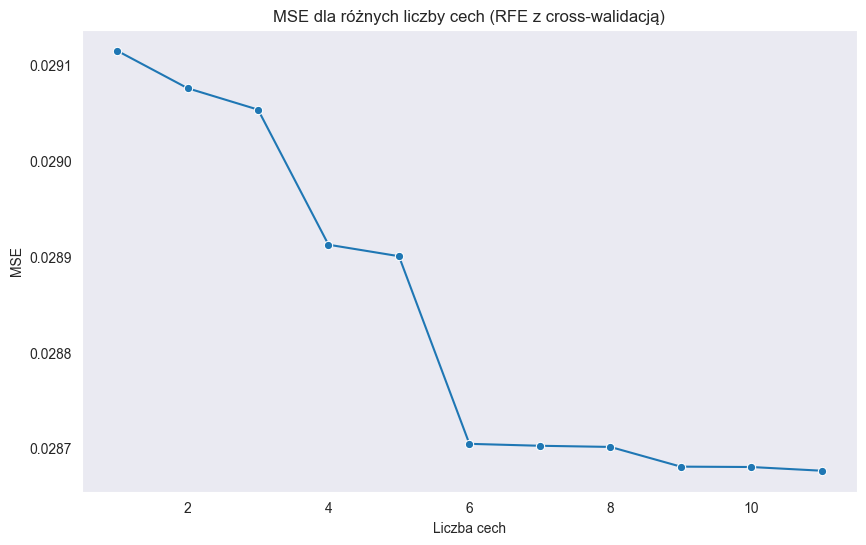

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import RFE
import numpy as np


def evaluate_rfe_models(X, y, n_features_list):
    results = []

    for n_features in n_features_list:
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
        X_rfe = rfe.fit_transform(X, y)

        scores = cross_val_score(LinearRegression(), X_rfe, y, cv=5, scoring='neg_mean_squared_error')
        mean_score = -np.mean(scores)
        results.append({
            "Features": n_features,
            "MSE": mean_score
        })

    return results


n_features_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
results = evaluate_rfe_models(X_train, y_train, n_features_list)
results_df = pd.DataFrame(results).sort_values(by=["Features", "MSE"])
print(results_df)

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="Features", y="MSE", marker="o")
plt.title("MSE dla różnych liczby cech (RFE z cross-walidacją)")
plt.xlabel("Liczba cech")
plt.ylabel("MSE")
plt.savefig("mse_rfe_crossval_plot.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.grid()
plt.show()

In [25]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=11)
selector = selector.fit(X_train, y_train)

selected_features_rfe = X_train.columns[selector.support_]
print(f"Selected features by RFE: {selected_features_rfe.tolist()}")

Selected features by RFE: ['year', 'make', 'model', 'trim', 'body', 'state', 'interior', 'seller', 'sale_hour', 'sale_minute', 'sale_weekday']


In [26]:
from sklearn.ensemble import ExtraTreesRegressor

model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train, y_train)

feature_importances = model_et.feature_importances_

feature_importances_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print(feature_importances_df)

# Filtrowanie cech na podstawie progu ważności
threshold = 0.01
selected_features_et = feature_importances_df[feature_importances_df["Importance"] > threshold]["Feature"].tolist()

print(f"Selected features by ExtraTreesRegressor: {selected_features_et}")


         Feature  Importance
0           year    0.434581
3           trim    0.143550
2          model    0.130810
1           make    0.112785
4           body    0.066496
7         seller    0.036016
6       interior    0.019776
5          state    0.017093
8      sale_hour    0.014892
10  sale_weekday    0.012649
9    sale_minute    0.011354
Selected features by ExtraTreesRegressor: ['year', 'trim', 'model', 'make', 'body', 'seller', 'interior', 'state', 'sale_hour', 'sale_weekday', 'sale_minute']


In [27]:
def fitness_function_with_cv(feature_mask):
    feature_mask = np.round(feature_mask).astype(int)
    selected_features = [i for i, bit in enumerate(feature_mask) if bit == 1]
    if not selected_features:
        return float('inf')

    X_selected = X_train.iloc[:, selected_features]

    scores = cross_val_score(HistGradientBoostingRegressor(random_state=42), X_selected, y_train, cv=5,
                             scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    
    penalty = 0.01 * len(selected_features)
    return mean_score + penalty


lb = [0] * X_train.shape[1]
ub = [1] * X_train.shape[1]

best_solution, best_score = pso(
    fitness_function_with_cv,
    lb,
    ub,
    swarmsize=15,
    maxiter=20
)

best_mask = np.round(best_solution).astype(int)
selected_features_pso = [i for i, bit in enumerate(best_mask) if bit == 1]
print(f"Selected features by PSO: {X_train.columns[selected_features_pso].tolist()}")


Stopping search: maximum iterations reached --> 20
Selected features by PSO: ['year']


In [28]:
selected_features_pso = X_train.columns[selected_features_pso]

In [29]:
def fitness_function_genetic(chromosome):
    # Konwersja chromosomu na wybrane cechy
    selected_features = [i for i, bit in enumerate(chromosome) if bit == 1]
    if not selected_features:  # Jeśli nie ma wybranych cech, kara za puste zestawy
        return float('inf')

    # Wybór danych treningowych dla wybranych cech
    X_selected = X_train.iloc[:, selected_features]

    scores = cross_val_score(
        HistGradientBoostingRegressor(random_state=42),
        X_selected, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    mean_score = -np.mean(scores)

    penalty = 0.01 * len(selected_features)
    return mean_score + penalty



In [30]:
import numpy as np

def initialize_population(pop_size, num_features):
    # Generowanie losowej populacji binarnych chromosomów
    return np.random.randint(2, size=(pop_size, num_features))


In [31]:
def tournament_selection(population, fitness_scores, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        # Wybieranie losowych uczestników turnieju
        participants_idx = np.random.choice(len(population), tournament_size, replace=False)
        best_idx = participants_idx[np.argmin(fitness_scores[participants_idx])]  # Najlepszy z turnieju
        selected.append(population[best_idx])
    return np.array(selected)


In [32]:
def crossover(parent1, parent2):
    # Jednopunktowe krzyżowanie
    point = np.random.randint(1, len(parent1) - 1)  # Punkt krzyżowania
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2


In [33]:
def mutate(chromosome, mutation_rate=0.1):
    # Mutacja z prawdopodobieństwem mutation_rate
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]  # Zamiana 0 na 1 lub 1 na 0
    return chromosome


In [34]:
def genetic_algorithm(X_train, y_train, num_generations=9, pop_size=50, mutation_rate=0.1):
    num_features = X_train.shape[1]
    population = initialize_population(pop_size, num_features)  # Inicjalizacja populacji

    for generation in range(num_generations):
        # Obliczanie fitness dla każdego chromosomu
        fitness_scores = np.array([fitness_function_genetic(chrom) for chrom in population])

        # Selekcja najlepszych chromosomów
        selected_population = tournament_selection(population, fitness_scores)

        # Tworzenie nowej populacji przez krzyżowanie
        new_population = []
        for i in range(0, len(selected_population), 2):
            parent1 = selected_population[i]
            parent2 = selected_population[i + 1] if i + 1 < len(selected_population) else selected_population[0]
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([child1, child2])

        # Mutacja nowej populacji
        new_population = [mutate(chrom, mutation_rate) for chrom in new_population]

        # Aktualizacja populacji
        population = np.array(new_population)

        # Wyświetlenie najlepszego wyniku fitness w danej generacji
        best_fitness = np.min(fitness_scores)
        print(f"Generacja {generation + 1}, najlepszy wynik fitness: {best_fitness:.4f}")

    best_idx = np.argmin(fitness_scores)
    best_chromosome = population[best_idx]
    return best_chromosome


In [35]:
best_chromosome = genetic_algorithm(X_train, y_train)

selected_features_genetic = [i for i, bit in enumerate(best_chromosome) if bit == 1]
print(f"Selected features by Genetic Algorithm: {X_train.columns[selected_features_genetic].tolist()}")

Generacja 1, najlepszy wynik fitness: 0.0386
Generacja 2, najlepszy wynik fitness: 0.0402
Generacja 3, najlepszy wynik fitness: 0.0367
Generacja 4, najlepszy wynik fitness: 0.0324
Generacja 5, najlepszy wynik fitness: 0.0324
Generacja 6, najlepszy wynik fitness: 0.0324
Generacja 7, najlepszy wynik fitness: 0.0324
Generacja 8, najlepszy wynik fitness: 0.0324
Generacja 9, najlepszy wynik fitness: 0.0324
Selected features by Genetic Algorithm: ['year', 'state', 'interior']


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import pandas as pd

# Słownik dla metod optymalizacji
methods = {
    "RFE": selected_features_rfe,
    "PSO": selected_features_pso,
    "ExtraTrees": selected_features_et,
    "Genetic Algorithm": selected_features_genetic,
}

# Wyniki dla każdej metody
results = []

# Model dla każdej metody
for method, selected_features in methods.items():
    if method == "Genetic Algorithm":
        # Dla Genetic Algorithm (features jako indeksy)
        X_train_selected = X_train.iloc[:, selected_features]
        X_valid_selected = X_valid.iloc[:, selected_features]
    else:
        # Dla innych metod (features jako nazwy kolumn)
        X_train_selected = X_train[selected_features]
        X_valid_selected = X_valid[selected_features]

    # Trening modelu
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X_train_selected, y_train)
    y_valid_pred = model.predict(X_valid_selected)

    # Obliczanie metryk
    mae = mean_absolute_error(y_valid, y_valid_pred)
    mse = mean_squared_error(y_valid, y_valid_pred)
    rmse = root_mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)

    results.append({
        "Method": method,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results)

# Posortuj wyniki według wybranej miary
results_df = results_df.sort_values(by="MAE", ascending=True)

print(results_df)

              Method       MAE       MSE      RMSE        R2
0                RFE  0.061844  0.007450  0.086312  0.848586
2         ExtraTrees  0.061844  0.007450  0.086312  0.848586
3  Genetic Algorithm  0.127318  0.026533  0.162891  0.460724
1                PSO  0.132992  0.028499  0.168818  0.420765


In [44]:
# Wybranie najlepszej metody na podstawie MAE
best_method_name = results_df.iloc[0]["Method"]
best_features = methods[best_method_name]

# Przygotowanie danych testowych
if best_method_name == "Genetic Algorithm":
    X_test_selected = X_test.iloc[:, best_features]
else:
    X_test_selected = X_test[best_features]

# Trening modelu na pełnym zbiorze treningowym
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train[best_features] if best_method_name != "Genetic Algorithm" else X_train.iloc[:, best_features], y_train)

# Przewidywanie na zbiorze testowym
y_test_pred = model.predict(X_test_selected)

# Obliczenie metryk na zbiorze testowym
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Wyniki dla najlepszej metody ({best_method_name}) na zbiorze testowym:")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Wyniki dla najlepszej metody (RFE) na zbiorze testowym:
MAE: 0.0617
RMSE: 0.0862
R²: 0.8493
